In [1]:
# switch to the project directory
%cd ..
# working directory should be ../pdi

/Users/lila/pdi


In [2]:
import sys
import os

module_path = os.path.abspath('src')

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from pdi.constants import (
    PARTICLES_DICT,
    TARGET_CODES,
    NUM_WORKERS,
)

In [4]:
config_common = {
    "bs": 512,
    "max_epochs": 40,
    "dropout": 0.1,
    "gamma": 0.9,
    "patience": 5,
    "patience_threshold": 0.001,
}

In [5]:
import torch
import torch.nn as nn

#torch.cuda.set_device(0)
torch.multiprocessing.set_sharing_strategy('file_system')
device = torch.device("cpu")

In [6]:
from pdi.data.preparation import FeatureSetPreparation, MeanImputation, DeletePreparation, RegressionImputation, EnsemblePreparation
from pdi.models import AttentionModel, NeuralNetEnsemble, NeuralNet
from pdi.data.constants import N_COLUMNS
from pdi.data.types import Split

EXPERIMENTS = {
    "Delete": {
        "data_preparation":
        DeletePreparation(),
        "config": {
            "h0": 64,
            "h1": 32,
            "h2": 16,
            "start_lr": 5e-4,
        },
        "model_class":
        NeuralNet,
        "model_args":
        lambda d_prep: [[
            N_COLUMNS, wandb.config.h0, wandb.config.h1, wandb.config.h2, 1
        ], nn.ReLU, wandb.config.dropout]
    },
    "Mean": {
        "data_preparation":
        MeanImputation(),
        "config": {
            "h0": 64,
            "h1": 32,
            "h2": 16,
            "start_lr": 5e-4,
        },
        "model_class":
        NeuralNet,
        "model_args":
        lambda d_prep: [[
            N_COLUMNS, wandb.config.h0, wandb.config.h1, wandb.config.h2, 1
        ], nn.ReLU, wandb.config.dropout]
    },
    "Regression": {
        "data_preparation":
        RegressionImputation(),
        "config": {
            "h0": 64,
            "h1": 32,
            "h2": 16,
            "start_lr": 5e-4,
        },
        "model_class":
        NeuralNet,
        "model_args":
        lambda d_prep: [[
            N_COLUMNS, wandb.config.h0, wandb.config.h1, wandb.config.h2, 1
        ], nn.ReLU, wandb.config.dropout],
    },
    "Ensemble": {
        "data_preparation":
        EnsemblePreparation(),
        "config": {
            "h0": 64,
            "h1": 32,
            "h2": 16,
            "start_lr": 5e-4,
        },
        "model_class":
        NeuralNetEnsemble,
        "model_args":
        lambda d_prep: [
            d_prep.get_group_ids(),
            [wandb.config.h0, wandb.config.h1, wandb.config.h2, 1],
            nn.ReLU,
            wandb.config.dropout,
        ],
    },
    "Proposed": {
        "data_preparation":
        FeatureSetPreparation(),
        "config": {
            "embed_in": N_COLUMNS + 1,
            "embed_hidden": 128,
            "d_model": 32,
            "ff_hidden": 128,
            "pool_hidden": 64,
            "num_heads": 2,
            "num_blocks": 2,
            "start_lr": 2e-4,
        },
        "model_class":
        AttentionModel,
        "model_args":
        lambda d_prep: [
            wandb.config.embed_in,
            wandb.config.embed_hidden,
            wandb.config.d_model,
            wandb.config.ff_hidden,
            wandb.config.pool_hidden,
            wandb.config.num_heads,
            wandb.config.num_blocks,
            nn.ReLU,
            wandb.config.dropout,
        ],
    },
}


In [7]:
import wandb
import os
import pandas as pd
from pdi.train import train
from pdi.constants import PARTICLES_DICT
from pdi.data.config import MODEL_NAME

from pdi.visualise import plot_learning_curve

def do_train(experiment_name, data_preparation, config, model_class,
             model_args):
    wandb_config = {**config_common, **config}

    train_loader, val_loader = data_preparation.prepare_dataloaders(
        wandb_config["bs"], NUM_WORKERS, [Split.TRAIN, Split.VAL])

    thresholds_df_list = []
    
    for target_code in TARGET_CODES:
        model_name = MODEL_NAME
        save_dir = f"models/{experiment_name}/{model_name}"
        os.makedirs(save_dir, exist_ok=True)
        save_path = f"{save_dir}/{PARTICLES_DICT[target_code]}.pt"
        with wandb.init(project=experiment_name,
                        config=wandb_config,
                        name=PARTICLES_DICT[target_code],
                        anonymous="allow") as run:
            # pos_weight = torch.tensor(data_preparation.pos_weight(target_code)).float().to(device)
            pos_weight = torch.tensor(1.0).to(device)
            wandb.log({"pos_weight": pos_weight.item()})

            model_init_args = model_args(data_preparation)
            model = model_class(*model_init_args).to(device)

            plot_dir = os.path.join(save_dir, "plots")
            os.makedirs(plot_dir, exist_ok=True)
            loss, val_loss = train(model, target_code, device, train_loader, val_loader,
                  pos_weight)

            save_dict = {
                "state_dict": model.state_dict(),
                "model_args": model_init_args,
                "model_thres": model.thres
            }
            
            thresholds_df_list.append(pd.DataFrame([(target_code, model.thres)], columns=["pdgPid", "threshold"]))
            
            torch.save(save_dict, save_path)

            label = PARTICLES_DICT[target_code]
            plot_learning_curve(loss, val_loss, label, plot_dir)

    thresholds_df = pd.concat(thresholds_df_list, ignore_index=True)
    thresholds_df.to_csv(f"{save_dir}/thresholds.csv", index=False)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anony-moose-206287007957090143. Use `wandb login --relogin` to force relogin


100%|██████████| 148/148 [00:09<00:00, 15.70it/s]


Epoch: 0, F1: 0.9234, Loss: 0.3045, Val_Loss:0.1954


100%|██████████| 148/148 [00:08<00:00, 17.13it/s]


Epoch: 1, F1: 0.9334, Loss: 0.1699, Val_Loss:0.1628


100%|██████████| 148/148 [00:09<00:00, 16.26it/s]


Epoch: 2, F1: 0.9399, Loss: 0.1570, Val_Loss:0.1506


100%|██████████| 148/148 [00:08<00:00, 16.61it/s]


Epoch: 3, F1: 0.9413, Loss: 0.1515, Val_Loss:0.1478


100%|██████████| 148/148 [00:09<00:00, 14.88it/s]


Epoch: 4, F1: 0.9416, Loss: 0.1493, Val_Loss:0.1478


100%|██████████| 148/148 [00:09<00:00, 16.18it/s]


Epoch: 5, F1: 0.9421, Loss: 0.1478, Val_Loss:0.1445


100%|██████████| 148/148 [00:09<00:00, 16.40it/s]


Epoch: 6, F1: 0.9427, Loss: 0.1466, Val_Loss:0.1440


100%|██████████| 148/148 [00:09<00:00, 16.10it/s]


Epoch: 7, F1: 0.9421, Loss: 0.1459, Val_Loss:0.1443


100%|██████████| 148/148 [00:08<00:00, 16.46it/s]


Epoch: 8, F1: 0.9427, Loss: 0.1453, Val_Loss:0.1428


100%|██████████| 148/148 [00:09<00:00, 16.26it/s]


Epoch: 9, F1: 0.9422, Loss: 0.1446, Val_Loss:0.1440


100%|██████████| 148/148 [00:08<00:00, 16.69it/s]


Epoch: 10, F1: 0.9429, Loss: 0.1446, Val_Loss:0.1429


100%|██████████| 148/148 [00:11<00:00, 13.45it/s]


Epoch: 11, F1: 0.9426, Loss: 0.1439, Val_Loss:0.1425


100%|██████████| 148/148 [00:09<00:00, 16.05it/s]


Epoch: 12, F1: 0.9430, Loss: 0.1433, Val_Loss:0.1417


100%|██████████| 148/148 [00:09<00:00, 15.94it/s]


Epoch: 13, F1: 0.9430, Loss: 0.1435, Val_Loss:0.1418


100%|██████████| 148/148 [00:09<00:00, 15.83it/s]


Epoch: 14, F1: 0.9429, Loss: 0.1431, Val_Loss:0.1415


100%|██████████| 148/148 [00:09<00:00, 16.12it/s]


Epoch: 15, F1: 0.9431, Loss: 0.1428, Val_Loss:0.1408


100%|██████████| 148/148 [00:09<00:00, 15.96it/s]


Epoch: 16, F1: 0.9431, Loss: 0.1426, Val_Loss:0.1410


100%|██████████| 148/148 [00:09<00:00, 16.05it/s]


Epoch: 17, F1: 0.9433, Loss: 0.1421, Val_Loss:0.1409


100%|██████████| 148/148 [00:09<00:00, 16.14it/s]


Epoch: 18, F1: 0.9431, Loss: 0.1422, Val_Loss:0.1408


100%|██████████| 148/148 [00:09<00:00, 16.44it/s]


Epoch: 19, F1: 0.9430, Loss: 0.1421, Val_Loss:0.1405


100%|██████████| 148/148 [00:09<00:00, 16.03it/s]


Epoch: 20, F1: 0.9429, Loss: 0.1419, Val_Loss:0.1407


100%|██████████| 148/148 [00:09<00:00, 16.25it/s]


Epoch: 21, F1: 0.9429, Loss: 0.1417, Val_Loss:0.1403


100%|██████████| 148/148 [00:09<00:00, 16.07it/s]


Epoch: 22, F1: 0.9431, Loss: 0.1420, Val_Loss:0.1403


100%|██████████| 148/148 [00:09<00:00, 15.72it/s]


Epoch: 23, F1: 0.9432, Loss: 0.1418, Val_Loss:0.1407


100%|██████████| 148/148 [00:09<00:00, 16.18it/s]


Epoch: 24, F1: 0.9432, Loss: 0.1420, Val_Loss:0.1403


100%|██████████| 148/148 [00:09<00:00, 15.58it/s]


Epoch: 25, F1: 0.9431, Loss: 0.1416, Val_Loss:0.1401


100%|██████████| 148/148 [00:08<00:00, 16.66it/s]


Epoch: 26, F1: 0.9431, Loss: 0.1415, Val_Loss:0.1404


100%|██████████| 148/148 [00:09<00:00, 16.06it/s]


Epoch: 27, F1: 0.9432, Loss: 0.1413, Val_Loss:0.1403
Finishing training early at epoch: 27


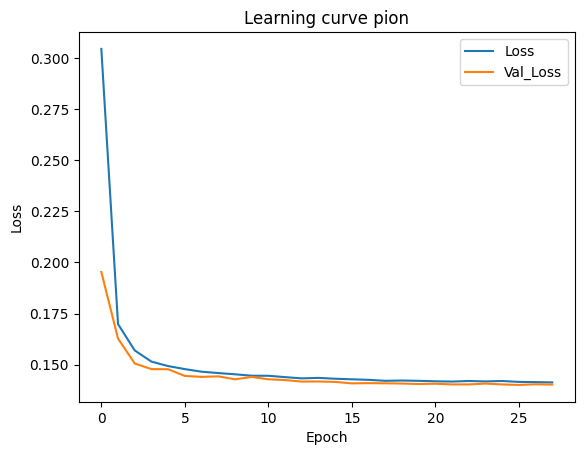

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▇▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▂
pos_weight,▁
scheduled_lr,█▇▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_f1,▁▅▇▇▇███████████████████████
val_loss,█▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▇▇▇▇████▇██▇████████▇███▇██
val_recall,▇▁▇█▇▇▆▆▇█▇▇█▇▇▇█▇▇▇▆██▇▇██▇
val_threshold,█▂▄▁▁▄▅▃▄▁▄▃▃▃▃▃▃▄▃▃▄▂▂▃▃▂▃▃
epoch,27
loss,7.14414


100%|██████████| 148/148 [00:09<00:00, 15.64it/s]


Epoch: 0, F1: 0.1789, Loss: 0.1553, Val_Loss:0.1175


100%|██████████| 148/148 [00:08<00:00, 16.72it/s]


Epoch: 1, F1: 0.7219, Loss: 0.0673, Val_Loss:0.0422


100%|██████████| 148/148 [00:09<00:00, 16.21it/s]


Epoch: 2, F1: 0.7362, Loss: 0.0445, Val_Loss:0.0374


100%|██████████| 148/148 [00:09<00:00, 16.00it/s]


Epoch: 3, F1: 0.7431, Loss: 0.0418, Val_Loss:0.0361


100%|██████████| 148/148 [00:08<00:00, 16.60it/s]


Epoch: 4, F1: 0.7337, Loss: 0.0400, Val_Loss:0.0389


100%|██████████| 148/148 [00:09<00:00, 15.86it/s]


Epoch: 5, F1: 0.7387, Loss: 0.0387, Val_Loss:0.0409


100%|██████████| 148/148 [00:08<00:00, 16.54it/s]


Epoch: 6, F1: 0.7448, Loss: 0.0386, Val_Loss:0.0349


100%|██████████| 148/148 [00:09<00:00, 16.20it/s]


Epoch: 7, F1: 0.7417, Loss: 0.0381, Val_Loss:0.0358


100%|██████████| 148/148 [00:08<00:00, 16.46it/s]


Epoch: 8, F1: 0.7335, Loss: 0.0376, Val_Loss:0.0378


100%|██████████| 148/148 [00:08<00:00, 16.54it/s]


Epoch: 9, F1: 0.7510, Loss: 0.0378, Val_Loss:0.0345


100%|██████████| 148/148 [00:09<00:00, 16.10it/s]


Epoch: 10, F1: 0.7501, Loss: 0.0372, Val_Loss:0.0342


100%|██████████| 148/148 [00:30<00:00,  4.88it/s]


Epoch: 11, F1: 0.7489, Loss: 0.0372, Val_Loss:0.0344


100%|██████████| 148/148 [00:09<00:00, 15.99it/s]


Epoch: 12, F1: 0.7333, Loss: 0.0369, Val_Loss:0.0381


100%|██████████| 148/148 [00:09<00:00, 15.20it/s]


Epoch: 13, F1: 0.7422, Loss: 0.0368, Val_Loss:0.0353


100%|██████████| 148/148 [00:09<00:00, 16.18it/s]


Epoch: 14, F1: 0.7389, Loss: 0.0366, Val_Loss:0.0346


100%|██████████| 148/148 [00:08<00:00, 16.71it/s]


Epoch: 15, F1: 0.7399, Loss: 0.0364, Val_Loss:0.0362
Finishing training early at epoch: 15


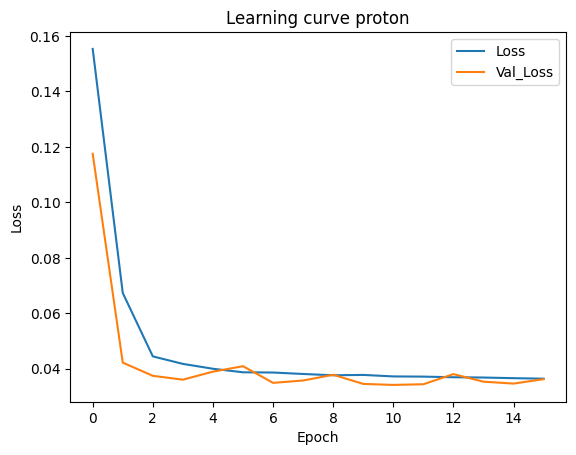

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▆▃▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pos_weight,▁
scheduled_lr,█▇▆▆▅▄▄▃▃▃▂▂▂▁▁▁
val_f1,▁███████████████
val_loss,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_precision,▁▇█▇██▇▇█▇▇▇▇▇█▇
val_recall,▁▆▅▇▄▅█▇▄█▇█▆▇▅▇
val_threshold,▁▄▆▃██▄▄█▄▄▄▇▄▅▅
epoch,15
loss,1.74487


100%|██████████| 148/148 [00:09<00:00, 15.48it/s]


Epoch: 0, F1: 0.2241, Loss: 0.1896, Val_Loss:0.1505


100%|██████████| 148/148 [00:09<00:00, 15.06it/s]


Epoch: 1, F1: 0.3750, Loss: 0.1363, Val_Loss:0.1187


100%|██████████| 148/148 [00:09<00:00, 15.82it/s]


Epoch: 2, F1: 0.5598, Loss: 0.1104, Val_Loss:0.0922


100%|██████████| 148/148 [00:09<00:00, 16.13it/s]


Epoch: 3, F1: 0.5729, Loss: 0.0958, Val_Loss:0.0868


100%|██████████| 148/148 [00:09<00:00, 15.16it/s]


Epoch: 4, F1: 0.5759, Loss: 0.0914, Val_Loss:0.0858


100%|██████████| 148/148 [00:09<00:00, 16.11it/s]


Epoch: 5, F1: 0.5800, Loss: 0.0890, Val_Loss:0.0843


100%|██████████| 148/148 [00:08<00:00, 16.51it/s]


Epoch: 6, F1: 0.5879, Loss: 0.0880, Val_Loss:0.0840


100%|██████████| 148/148 [00:08<00:00, 17.04it/s]


Epoch: 7, F1: 0.5906, Loss: 0.0872, Val_Loss:0.0828


100%|██████████| 148/148 [00:09<00:00, 15.56it/s]


Epoch: 8, F1: 0.5875, Loss: 0.0863, Val_Loss:0.0837


100%|██████████| 148/148 [00:09<00:00, 15.84it/s]


Epoch: 9, F1: 0.5898, Loss: 0.0856, Val_Loss:0.0831


100%|██████████| 148/148 [00:09<00:00, 15.33it/s]


Epoch: 10, F1: 0.5827, Loss: 0.0856, Val_Loss:0.0849


100%|██████████| 148/148 [00:09<00:00, 16.27it/s]


Epoch: 11, F1: 0.5906, Loss: 0.0850, Val_Loss:0.0826


100%|██████████| 148/148 [00:08<00:00, 16.53it/s]


Epoch: 12, F1: 0.5903, Loss: 0.0848, Val_Loss:0.0820


100%|██████████| 148/148 [00:09<00:00, 15.54it/s]


Epoch: 13, F1: 0.5911, Loss: 0.0849, Val_Loss:0.0818


100%|██████████| 148/148 [00:09<00:00, 15.61it/s]


Epoch: 14, F1: 0.5896, Loss: 0.0845, Val_Loss:0.0821


100%|██████████| 148/148 [00:09<00:00, 16.10it/s]


Epoch: 15, F1: 0.5919, Loss: 0.0842, Val_Loss:0.0823


100%|██████████| 148/148 [00:09<00:00, 16.33it/s]


Epoch: 16, F1: 0.5918, Loss: 0.0841, Val_Loss:0.0818


100%|██████████| 148/148 [00:08<00:00, 16.52it/s]


Epoch: 17, F1: 0.5935, Loss: 0.0840, Val_Loss:0.0818


100%|██████████| 148/148 [00:09<00:00, 16.05it/s]


Epoch: 18, F1: 0.5924, Loss: 0.0837, Val_Loss:0.0816


100%|██████████| 148/148 [00:09<00:00, 16.23it/s]


Epoch: 19, F1: 0.5913, Loss: 0.0837, Val_Loss:0.0816


100%|██████████| 148/148 [00:09<00:00, 15.69it/s]


Epoch: 20, F1: 0.5925, Loss: 0.0835, Val_Loss:0.0816


100%|██████████| 148/148 [00:09<00:00, 15.39it/s]


Epoch: 21, F1: 0.5916, Loss: 0.0837, Val_Loss:0.0814


100%|██████████| 148/148 [00:09<00:00, 15.89it/s]


Epoch: 22, F1: 0.5916, Loss: 0.0835, Val_Loss:0.0822


100%|██████████| 148/148 [00:10<00:00, 14.12it/s]


Epoch: 23, F1: 0.5910, Loss: 0.0833, Val_Loss:0.0815
Finishing training early at epoch: 23


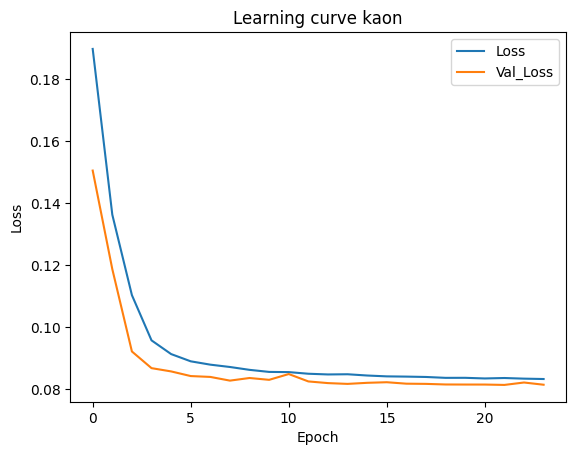

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▆▅▄▃▂▂▂▁▂▂▂▁▂▂▂▁▁▂▁▁▁▂▂▂▁▂▁▁▁▁▂▂▁▂▁▁▂▂▂
pos_weight,▁
scheduled_lr,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_f1,▁▄▇█████████████████████
val_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▇▇▇█▇███▇▇▇█▇▇█▇█▇▇█▇█
val_recall,█▄▃▄▃▁▃▂▂▂▃▃▄▂▃▃▃▄▁▄▃▂▄▃
val_threshold,▁▃▆▆▆█▇▇▇▇▇▇▆▇█▆▆▆█▆▇▇▆▇
epoch,23
loss,4.31056


100%|██████████| 148/148 [00:09<00:00, 14.88it/s]


Epoch: 0, F1: 0.9338, Loss: 0.2421, Val_Loss:0.1657


100%|██████████| 148/148 [00:11<00:00, 13.27it/s]


Epoch: 1, F1: 0.9417, Loss: 0.1522, Val_Loss:0.1427


100%|██████████| 148/148 [00:09<00:00, 15.72it/s]


Epoch: 2, F1: 0.9433, Loss: 0.1434, Val_Loss:0.1387


100%|██████████| 148/148 [00:09<00:00, 15.71it/s]


Epoch: 3, F1: 0.9430, Loss: 0.1415, Val_Loss:0.1382


100%|██████████| 148/148 [00:09<00:00, 15.37it/s]


Epoch: 4, F1: 0.9433, Loss: 0.1404, Val_Loss:0.1370


100%|██████████| 148/148 [00:09<00:00, 16.22it/s]


Epoch: 5, F1: 0.9437, Loss: 0.1394, Val_Loss:0.1360


100%|██████████| 148/148 [00:09<00:00, 15.93it/s]


Epoch: 6, F1: 0.9431, Loss: 0.1391, Val_Loss:0.1372


100%|██████████| 148/148 [00:08<00:00, 17.55it/s]


Epoch: 7, F1: 0.9439, Loss: 0.1384, Val_Loss:0.1361


100%|██████████| 148/148 [00:08<00:00, 16.61it/s]


Epoch: 8, F1: 0.9442, Loss: 0.1379, Val_Loss:0.1360


100%|██████████| 148/148 [00:09<00:00, 16.35it/s]


Epoch: 9, F1: 0.9438, Loss: 0.1375, Val_Loss:0.1364


100%|██████████| 148/148 [00:08<00:00, 16.62it/s]


Epoch: 10, F1: 0.9443, Loss: 0.1373, Val_Loss:0.1351


100%|██████████| 148/148 [00:09<00:00, 16.33it/s]


Epoch: 11, F1: 0.9440, Loss: 0.1371, Val_Loss:0.1351


100%|██████████| 148/148 [00:09<00:00, 15.96it/s]


Epoch: 12, F1: 0.9444, Loss: 0.1366, Val_Loss:0.1346


100%|██████████| 148/148 [00:09<00:00, 16.12it/s]


Epoch: 13, F1: 0.9438, Loss: 0.1364, Val_Loss:0.1353


100%|██████████| 148/148 [00:09<00:00, 15.94it/s]


Epoch: 14, F1: 0.9442, Loss: 0.1361, Val_Loss:0.1341


100%|██████████| 148/148 [00:10<00:00, 14.50it/s]


Epoch: 15, F1: 0.9444, Loss: 0.1361, Val_Loss:0.1339


100%|██████████| 148/148 [00:09<00:00, 15.61it/s]


Epoch: 16, F1: 0.9443, Loss: 0.1358, Val_Loss:0.1339


100%|██████████| 148/148 [00:09<00:00, 16.39it/s]


Epoch: 17, F1: 0.9439, Loss: 0.1358, Val_Loss:0.1345


100%|██████████| 148/148 [00:09<00:00, 16.32it/s]


Epoch: 18, F1: 0.9441, Loss: 0.1355, Val_Loss:0.1343


100%|██████████| 148/148 [00:09<00:00, 15.92it/s]


Epoch: 19, F1: 0.9440, Loss: 0.1354, Val_Loss:0.1344
Finishing training early at epoch: 19


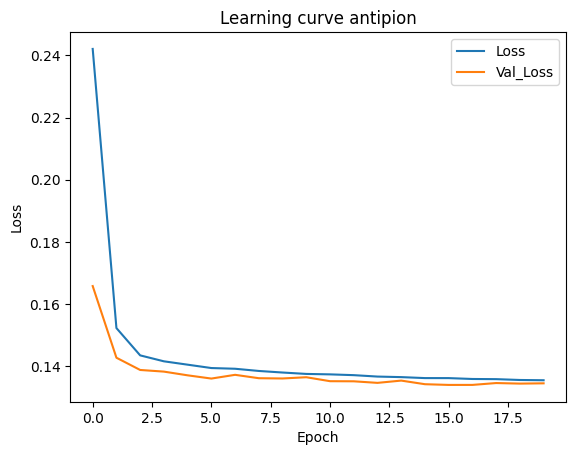

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pos_weight,▁
scheduled_lr,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_f1,▁▆▇▇▇█▇█████████████
val_loss,█▃▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▄▄▄▆▄▇▅▇▆█▇▅▄███▄▃
val_recall,▁▆▇▇▇▆▇▆▇▆▇▅▆▇█▆▆▅██
val_threshold,█▁▆▇▅▅▂▆▆▇▆▆▄▄▂▅▆▆▂▄
epoch,19
loss,7.00218


100%|██████████| 148/148 [00:09<00:00, 16.06it/s]


Epoch: 0, F1: 0.1540, Loss: 0.1443, Val_Loss:0.1097


100%|██████████| 148/148 [00:09<00:00, 15.70it/s]


Epoch: 1, F1: 0.5213, Loss: 0.0687, Val_Loss:0.0524


100%|██████████| 148/148 [00:08<00:00, 16.98it/s]


Epoch: 2, F1: 0.6920, Loss: 0.0449, Val_Loss:0.0368


100%|██████████| 148/148 [00:08<00:00, 16.73it/s]


Epoch: 3, F1: 0.7034, Loss: 0.0394, Val_Loss:0.0388


100%|██████████| 148/148 [00:08<00:00, 16.77it/s]


Epoch: 4, F1: 0.7049, Loss: 0.0375, Val_Loss:0.0342


100%|██████████| 148/148 [00:09<00:00, 16.20it/s]


Epoch: 5, F1: 0.7128, Loss: 0.0368, Val_Loss:0.0334


100%|██████████| 148/148 [00:09<00:00, 16.36it/s]


Epoch: 6, F1: 0.7161, Loss: 0.0359, Val_Loss:0.0329


100%|██████████| 148/148 [00:09<00:00, 16.41it/s]


Epoch: 7, F1: 0.7190, Loss: 0.0355, Val_Loss:0.0331


100%|██████████| 148/148 [00:08<00:00, 16.47it/s]


Epoch: 8, F1: 0.7173, Loss: 0.0350, Val_Loss:0.0332


100%|██████████| 148/148 [00:08<00:00, 17.63it/s]


Epoch: 9, F1: 0.7123, Loss: 0.0350, Val_Loss:0.0331


100%|██████████| 148/148 [00:08<00:00, 17.37it/s]


Epoch: 10, F1: 0.7150, Loss: 0.0347, Val_Loss:0.0330


100%|██████████| 148/148 [00:08<00:00, 17.45it/s]


Epoch: 11, F1: 0.7170, Loss: 0.0344, Val_Loss:0.0327


100%|██████████| 148/148 [00:08<00:00, 17.41it/s]


Epoch: 12, F1: 0.7213, Loss: 0.0344, Val_Loss:0.0322


100%|██████████| 148/148 [00:08<00:00, 17.14it/s]


Epoch: 13, F1: 0.7225, Loss: 0.0341, Val_Loss:0.0323


100%|██████████| 148/148 [00:08<00:00, 17.08it/s]


Epoch: 14, F1: 0.7221, Loss: 0.0341, Val_Loss:0.0320


100%|██████████| 148/148 [00:09<00:00, 15.23it/s]


Epoch: 15, F1: 0.7142, Loss: 0.0340, Val_Loss:0.0326


100%|██████████| 148/148 [00:09<00:00, 16.25it/s]


Epoch: 16, F1: 0.7228, Loss: 0.0338, Val_Loss:0.0321


100%|██████████| 148/148 [00:08<00:00, 16.86it/s]


Epoch: 17, F1: 0.7207, Loss: 0.0337, Val_Loss:0.0320


100%|██████████| 148/148 [00:08<00:00, 16.48it/s]


Epoch: 18, F1: 0.7207, Loss: 0.0339, Val_Loss:0.0320
Finishing training early at epoch: 18


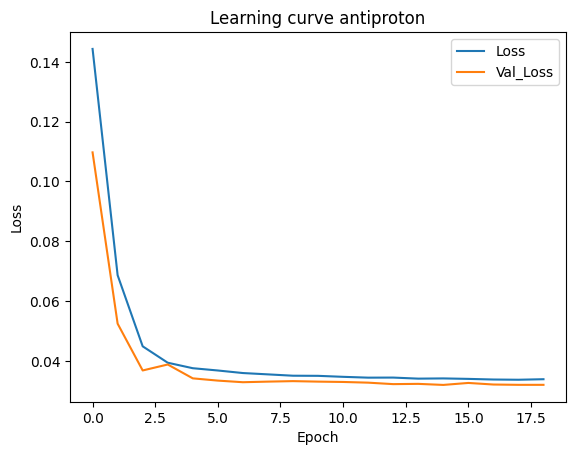

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▅▅▃▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
pos_weight,▁
scheduled_lr,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁
val_f1,▁▆█████████████████
val_loss,█▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▅▇▇███▇█████▇▇███▇
val_recall,▅▁▇█▆▇▆█▇▆▇▆▇██▇▇▇█
val_threshold,▁▆▃█▆▆▆▅▇▇▆▆▅▆▅▆▆▆▅
epoch,18
loss,1.67026


100%|██████████| 148/148 [00:09<00:00, 16.42it/s]


Epoch: 0, F1: 0.1800, Loss: 0.1952, Val_Loss:0.1498


100%|██████████| 148/148 [00:09<00:00, 16.02it/s]


Epoch: 1, F1: 0.3106, Loss: 0.1331, Val_Loss:0.1145


100%|██████████| 148/148 [00:09<00:00, 15.83it/s]


Epoch: 2, F1: 0.5108, Loss: 0.1064, Val_Loss:0.0912


100%|██████████| 148/148 [00:08<00:00, 16.90it/s]


Epoch: 3, F1: 0.5624, Loss: 0.0878, Val_Loss:0.0794


100%|██████████| 148/148 [00:09<00:00, 16.42it/s]


Epoch: 4, F1: 0.5719, Loss: 0.0833, Val_Loss:0.0778


100%|██████████| 148/148 [00:08<00:00, 16.64it/s]


Epoch: 5, F1: 0.5586, Loss: 0.0810, Val_Loss:0.0799


100%|██████████| 148/148 [00:09<00:00, 16.11it/s]


Epoch: 6, F1: 0.5603, Loss: 0.0804, Val_Loss:0.0788


100%|██████████| 148/148 [00:09<00:00, 16.23it/s]


Epoch: 7, F1: 0.5756, Loss: 0.0794, Val_Loss:0.0764


100%|██████████| 148/148 [00:09<00:00, 16.19it/s]


Epoch: 8, F1: 0.5745, Loss: 0.0789, Val_Loss:0.0759


100%|██████████| 148/148 [00:09<00:00, 16.24it/s]


Epoch: 9, F1: 0.5758, Loss: 0.0787, Val_Loss:0.0757


100%|██████████| 148/148 [00:09<00:00, 16.10it/s]


Epoch: 10, F1: 0.5724, Loss: 0.0782, Val_Loss:0.0756


100%|██████████| 148/148 [00:09<00:00, 16.02it/s]


Epoch: 11, F1: 0.5766, Loss: 0.0780, Val_Loss:0.0758


100%|██████████| 148/148 [00:09<00:00, 16.33it/s]


Epoch: 12, F1: 0.5752, Loss: 0.0778, Val_Loss:0.0757


100%|██████████| 148/148 [00:09<00:00, 15.83it/s]


Epoch: 13, F1: 0.5723, Loss: 0.0773, Val_Loss:0.0759


100%|██████████| 148/148 [00:09<00:00, 16.31it/s]


Epoch: 14, F1: 0.5749, Loss: 0.0774, Val_Loss:0.0760


100%|██████████| 148/148 [00:09<00:00, 16.12it/s]


Epoch: 15, F1: 0.5784, Loss: 0.0771, Val_Loss:0.0754


100%|██████████| 148/148 [00:09<00:00, 16.12it/s]


Epoch: 16, F1: 0.5800, Loss: 0.0772, Val_Loss:0.0751


100%|██████████| 148/148 [00:09<00:00, 16.01it/s]


Epoch: 17, F1: 0.5772, Loss: 0.0770, Val_Loss:0.0756


100%|██████████| 148/148 [00:09<00:00, 15.69it/s]


Epoch: 18, F1: 0.5801, Loss: 0.0767, Val_Loss:0.0751


100%|██████████| 148/148 [00:09<00:00, 15.94it/s]


Epoch: 19, F1: 0.5795, Loss: 0.0769, Val_Loss:0.0754
Finishing training early at epoch: 19


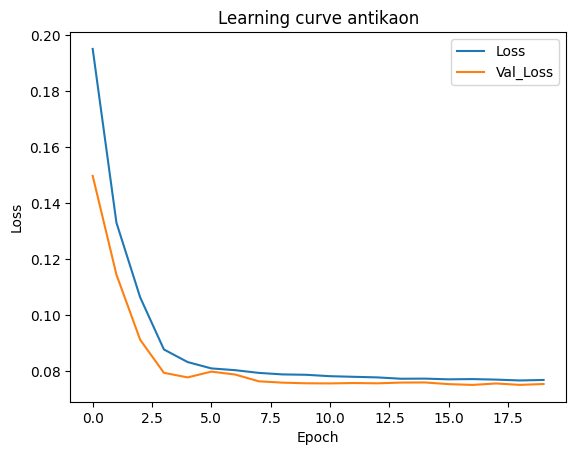

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁
pos_weight,▁
scheduled_lr,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_f1,▁▃▇█████████████████
val_loss,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▂▆▇██████▇█████████
val_recall,▁█▇█▆▆▆▇▇▇█▇▇▇▆▇▇▇▇▇
val_threshold,▁▄▆▅██▇▆▇▆▅▇▇▆▇▆▆▇▇▇
epoch,19
loss,3.4161


In [8]:
do_train("Proposed", **EXPERIMENTS["Proposed"])

In [ ]:
do_train("Delete", **EXPERIMENTS["Delete"])

In [ ]:
do_train("Mean", **EXPERIMENTS["Mean"])

In [ ]:
do_train("Regression", **EXPERIMENTS["Regression"])

In [ ]:
do_train("Ensemble", **EXPERIMENTS["Ensemble"])